In [2]:
#Use this cell to import all the required libraries.

#import common toolkits
import pandas as pd
import numpy as np
import re
import nltk
import random
import time
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#import Classifier, Scaler and Evaluation tools
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score 
from sklearn.datasets import make_classification 
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

# from wordcloud import WordCloud
#import NLP toolkits
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore

#download necessary toolkits 
nltk.download('wordnet')
#setting for ignoring warning prompts
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86176\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#your work should only start with the following code

#read file and transform to DataFrame
df = pd.read_excel("Assignment_Data.xlsx")
df2 = df.copy()


#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

    I firstly did a basic filter of the dataset, removing columns with greater than half of the empty values, and then removing rows with null values.
    
    It was also found that 'post_retweets', 'post_quotes' both had more than 90% 0 values, so they were removed.

    A point plot was observed for 'user_mentions', and it was found that there was an almost perfect average distribution from the minimum to the maximum values (0-12), so it was determined that the data in this column did not affect the results, therefore 'user_mentions' column had been removed.
    
    Point plot observations were made on the other metadata and found that extreme values existed in most of the metadata, so 5% of the outlier was dropped. Ather this operation, the data became more evenly distributed and the trend of the dot plot has become more stable.
    
    It was also found that the remaining two columns of the post metadata() were positively correlated with misinformation, so we were prepared to extract the values of 0 and non-0 respectively, and designed a special function to facilitate the subsequent operation.



In [4]:
def get_dummies_special_values(col,num):
    '''
    Convert a column that is decided to dummilized to a specific value,or non-specific value.
    For example,for post_replies,0 is the specific value. index with value 0 will marked as 1.
    It also works for opposite. An 2D-array would returned just like get_dummies() does.
   
    Parameters:
    col(Series):The column in operating DataFrame.
    num(float): The specific value to devide values.
    
    Return:
    
    '''
    pos_output = []
    neg_putput = []
    col_list = col.tolist()
    for i in range(len(col_list)):
        if col_list[i] <= num:
            neg_putput.append(1)
            pos_output.append(0)
        else:
            pos_output.append(1)
            neg_putput.append(0)
    return np.vstack((pos_output, neg_putput)).transpose()

#columns 'user_following' and 'user_country' missing over 50% values, dropped and reform df3.
df3 = df2.drop(columns=['user_following','user_country']).dropna().reset_index(drop=True)
#drop rows with null attributes.
df4 = df3.copy().dropna()

#removal for meaningless column('news_author'), and columns with too many repeated values.
df4 = df4.drop(columns=['news_author','post_retweets','post_quotes','user_mentions'])
df5 = df4.copy().reset_index(drop=True)

#clean 5% largest outliers for user_social_columns to reduce the impact of noisy data
df5_cleaned = df5.copy()
user_social_columns = ['user_followers','user_friends','user_favourites','user_tweets_count','user_tweet_count_lists']
user_outlier_margin = df5_cleaned[user_social_columns].quantile(0.95)
for i in range(len(user_social_columns)):
    user_condition = df5[user_social_columns[i]] <= user_outlier_margin[i]
    df5_cleaned = df5_cleaned[user_condition]
    
#use df6 for further work and feature addition.
df6 = df5_cleaned.copy().reset_index(drop=True)

# Text preparation

    For the Dataframes that were already preprocessed, the necessary text processing was performed: tokenlization, lowercasing, symbol removal, stopwords removal, and also lemmatisation.
    
    After the first-round check, wordcloud was used to find the keywords where the misinformation was true or false separately, no significant differences were found. However words that were found as main components but not meaningful were also iterated into the list of stopwords.
    
    A tf-idf calculation and dimensionality reduction process was performed and also analysed the sentiment values for each textual content.
    
    Topic probabilities were predicted for the textual content. Based on the partitioning of tweets, the number of topics was designed as 7.


In [5]:
related_tweet_Data = (df6["related_tweet"].apply(word_tokenize)).apply(lambda x: [word.lower() for word in x])
#add meaningless but high frequency words in the dataset,for those are detected by wordcloud.
X_stopwords_extension=['s','amp','','u','nt']
X_stopwords = stopwords.words("English")+X_stopwords_extension
related_tweet_Data = related_tweet_Data.apply(lambda x: [word for word in x if word not in X_stopwords]) 
related_tweet_Data = related_tweet_Data.apply(lambda tokens: [re.sub('[^a-zA-Z]', '', token) for token in tokens])
#text-lemmatizer and put that back to sentences
lemmatizer = WordNetLemmatizer()
Lemmatized_related_tweet_Data = related_tweet_Data.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
Preprocessed_tweet_Data =  [' '.join(i) for i in Lemmatized_related_tweet_Data]

#generate tf-idf matrix and Dimensionality Reduction
cv = CountVectorizer()
bag_of_words = cv.fit_transform(Preprocessed_tweet_Data)
tfidf_transformer = TfidfTransformer(norm="l2")
tfidf_matrix = tfidf_transformer.fit_transform(bag_of_words)
# feature_names = cv.get_feature_names_out()
My_SVD = TruncatedSVD(n_components=5)
SVD_Note= My_SVD.fit_transform(tfidf_matrix)

#set Sentiment Analyzer and LDA model for further feature engineering
Tweet_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df6["related_tweet"]:
    text_score = Tweet_sentiment_analyser.polarity_scores(sentence)
    sentimental_text_list.append(text_score)

Tweet_id2word = corpora.Dictionary(Lemmatized_related_tweet_Data)
corpus = [Tweet_id2word.doc2bow(text) for text in Lemmatized_related_tweet_Data]
lda_model = LdaMulticore(corpus=corpus, id2word=Tweet_id2word,num_topics=7, random_state= 0)

#Use wordcloud to identify feature words in dataset
# #Tried to use wordcloud to analyze significant words. Result shows that wordcloud doesn't match this sample. 
# wordcloud_df = pd.DataFrame({
#     'Preprocessed_tweet_Data' : Preprocessed_tweet_Data,
#     'Misinformation' : df6['misinformation']
# })
# mis_text = wordcloud_df[wordcloud_df['Misinformation'] == 1].copy()['Preprocessed_tweet_Data'].tolist()
# mis_text = ' '.join(mis_text)
# true_text = wordcloud_df[wordcloud_df['Misinformation'] == 0].copy()['Preprocessed_tweet_Data'].tolist()
# true_text = ' '.join(true_text)
# mis_worldcloud = WordCloud(width=800, height=400, background_color='white').generate(mis_text)
# true_worldcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(mis_worldcloud, interpolation='bilinear')
# plt.title('mis_worldcloud')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(true_worldcloud, interpolation='bilinear')
# plt.title('true_worldcloud')
# plt.axis('off')
# plt.show()

# Feature engineering

    Using the SVD model, the dimensionality reduced Tf-idf vectors were added to df6. After several model tests, it was found that retaining only compound socre to represent the sentiment of the text had higher accuracy. Only the Topics that the text is most likely to belong to are also selected to streamline the number of columns of feature variables.

    For the post metadata type, a self-written function: get_dummies_special_values() was used to specially dummilised the metadata to distinguish whether it was zero or not.

    Use the K-Mean model to convert the post metadata into a column of feature variables, which are markers for clusters. The elbow method was used to determine that K in K-Mean is best taken as 3.

    For the User metadata type, principal component analysis(PCA) was used to de-quantify this data and downscale it to 3 columns.


##### Feature 1 generation: NLP Labels

In [6]:
#Add SVD labels into dataframe(df6)
df6[["SVD1","SVD2","SVD3","SVD4","SVD5"]] = SVD_Note
df_Sentiment = pd.DataFrame(sentimental_text_list)

#Add sentiment labels into dataframe(df6)
df6[['neg','neu','pos','compound']] = df_Sentiment
cm = CoherenceModel(model=lda_model, corpus=corpus, texts=Lemmatized_related_tweet_Data,dictionary=Tweet_id2word, coherence='u_mass')
coherence = cm.get_coherence() 

#calculate topic probabilities,then add the most-probable topic label into dataframe(df6)
topic_probabilities = list(lda_model.get_document_topics(bow=corpus,minimum_probability=0.05))
probabilities = [[prob for topic, prob in row] for row in topic_probabilities]
most_probable = [prob.index(max(prob)) for prob in probabilities]
df6['Probable_Topic'] = most_probable

##### Feature 2 generation: Post metadata's clusters Labels

In [7]:
#use get_dummies_special_values(), generate dummilized label for columns 'post_replies' and 'post_favourites'
post_replies_flags = get_dummies_special_values(df6['post_replies'],0)
post_favourites_flags = get_dummies_special_values(df6['post_favourites'],0)
post_flags = pd.DataFrame(post_replies_flags,columns = ['zero_pr','nonzero_pr'])
post_flags[['zero_pf','nonzero_pf']] = post_favourites_flags

#Standardlize the dummilized label for these two columns
post_standard_data = StandardScaler().fit_transform(post_flags)

#set up K-Means model to transform datas into one-column value,as the clusters' label.
post_kmeans = KMeans(n_clusters=3,max_iter = 10000)
post_kmeans.fit(post_standard_data)
kMeansLables = post_kmeans.labels_

#add labels as a column into dataframe(df6)
df6['post_clusters_label'] = kMeansLables

##### Feature 3 generation: Dimensionality reduced user metadata by Principal component analysis(PCA)

In [8]:
#Select user metadata columns,then standardlize.
user_social_data = df6[['user_followers','user_friends','user_favourites','user_tweets_count','user_tweet_count_lists']]
standard_user_data = StandardScaler().fit_transform(user_social_data)

#set up Principal component analysis(PCA) model to reduce these data into 3 columns.
user_pca = PCA(n_components=3)
User_data_dim = user_pca.fit_transform(user_social_data)

#add PCA-operated data columns into dataframe(df6)
df6[["User_dim1","User_dim2",'User_dim3']] = User_data_dim

# Model building & evaluation
Once you have found the most optimal model, you should only only show the model building and evaluation here!

    I used an ensemble classifier, which is divided into two sub-models: for all feature variables, versus just for NLP feature variables.

    For sub-model 1, I used Random Forest and a separate decision tree. This is because they are good at dealing with large data and have the ability to avoid overfitting.
    
    For sub-model2, I use a Naive Bayes model with 5-Nearest Neighbors to analyse the NLP variables. Experiments proved that analysing only NLP variables resulted in much greater accuracy than global analysis, also because both models performed better in predicting NLP features.

    I have dropped the use of Support Vector Machines in this model due to excessive training time, black-box effects & overfitting issues.

    Since the two sub-models took different feature datasets for analysis (because of the different number of columns of X's selected), I ran each classifier individually and stored the predictions and composed new Dataframes with a dataset full of 0's and 1's that were used as predictions.

    They will be used in a new voting classifier. This solves the problem that traditional voting classifier can only fit one feature dataset. The quadratic voting mechanism also avoids the risk of overfitting. However, due to the use of hard voting in this model, it may aggravate the black box effect.

    This model de-predicted the results for the training data and generated the confusion matrix. The data from the matrix indicates that this model is well capable and possesses 77% accuracy and recall. Although the individual performance is not as good as the individuals in the aggregated classification, the voting mechanism stabilises the model's performance.


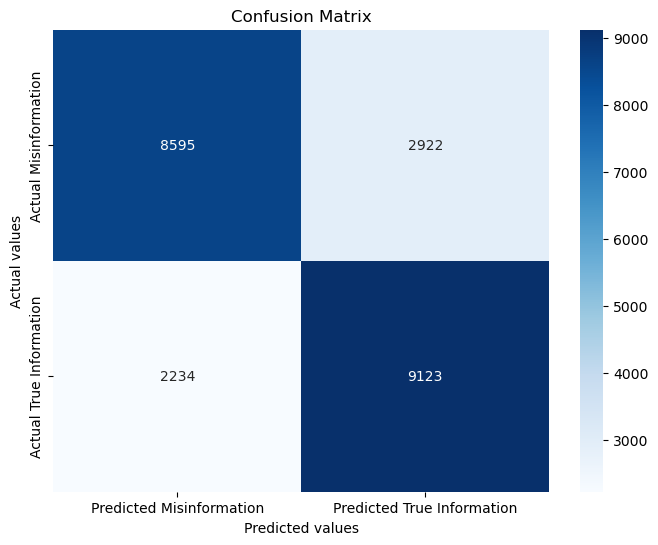

                  precision    recall  f1-score   support

True Information       0.79      0.75      0.77     11517
  Misinformation       0.76      0.80      0.78     11357

        accuracy                           0.77     22874
       macro avg       0.78      0.77      0.77     22874
    weighted avg       0.78      0.77      0.77     22874



In [9]:
df6 = df6.dropna()
#choose the following data as feature columns for random forest and decision tree models.
X = df6[['post_clusters_label','User_dim1','User_dim2','User_dim3','SVD1','SVD2','SVD3','SVD4','SVD5','compound','Probable_Topic']]
#'misinformation' as the target variable.
y = df6['misinformation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

'''
set up a random forest model as global prediction.
in 5-fold CV, this model got 77%'s' accuracy and 0.85 as roc_auc,as average.
'''
rf_model = RandomForestClassifier(n_estimators=30,max_depth=24).fit(X_train,y_train)

'''
set up a decision tree model as global prediction.
in 5-fold CV, this model got 70%'s' accuracy and 0.70 as roc_auc,as average.
'''
dt_model = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth = 25,ccp_alpha=0.05).fit(X_train,y_train)
# dt_scores = cross_validate(dt_model, X, y, cv=5, scoring=['accuracy', 'recall','precision',
# 'f1', 'roc_auc'])

#state a sub-group label that only related with NLP labels, for Naive Bayes and K-nearest neighbor models.
nlp_model_label = ['SVD1','SVD2','SVD3','SVD4','SVD5','compound','Probable_Topic']

'''
set up a naive bayes model as NLP data focused prediction.
in 5-fold CV, this model got 68%'s' accuracy and 0.76 as roc_auc,as average.
'''
nb_Model = GaussianNB().fit(X_train[nlp_model_label],y_train)
# nb_scores = cross_validate(nb_Model, X[nlp_model_label], y, cv=5, scoring=['accuracy', 'recall','precision',
# 'f1', 'roc_auc'])

'''
set up a 5-nearest neighbors model as NLP data focused prediction.
in 5-fold CV, this model got 74%'s' accuracy and 0.82 as roc_auc,as average.
'''
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train[nlp_model_label],y_train)
# knn_scores = cross_validate(knn_model, X[nlp_model_label], y, cv=5, scoring=['accuracy', 'recall','precision',
# 'f1', 'roc_auc'])

#collect prediction value of 4 models
rf_predict_result = rf_model.predict(X_test)
dt_predict_result = dt_model.predict(X_test)
nb_predict_result = nb_Model.predict(X_test[nlp_model_label])
knn_predict_result = knn_model.predict(X_test[nlp_model_label])

#combine the prediction into a dataframe,for further voting operation
combined_features = pd.DataFrame({
    'rf_predict_result': rf_predict_result,
    'dt_predict_result': dt_predict_result,
    'nb_predict_result': nb_predict_result,
    'knn_predict_result': knn_predict_result
})

#set up a voting classifier to ensemble the above classifier.
#voting_classifier is the final classifier of this model ,but it relies on other 4 model's prediction results.
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('dt', dt_model),
    ('nb', nb_Model),
    ('knn', knn_model)
], voting='hard')

#fit the prediction of 4 classifier, voting by voting_classifier(just like voted X_test result). 
voting_classifier.fit(combined_features, y_test)

#voting_pred is the final prediction of target variable.
voting_pred = voting_classifier.predict(combined_features)

#generate a confusion matrix and plot it to show this model's final performance.
combined_cm = confusion_matrix(y_test, voting_pred) 
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Misinformation',
'Predicted True Information'],yticklabels=['Actual Misinformation', 'Actual True Information'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, voting_pred,target_names=['True Information','Misinformation']))